"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
from scipy.stats import beta

import sys                                                                       
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')                   
from visualize import gen_square_subplots, imshow, firing_overview       

In [42]:
# Some poisson spiking
states = 3
trials = 15
neurons = 7
length = 500
fit = int(1e5)
samples = 2000

true_tau = np.cumsum(np.random.random((trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[:,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

state_inds = np.concatenate([np.zeros((trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:,:-1]

n_components = 2
true_lambda = np.random.random((n_components,states, neurons))

component_inds = np.random.choice(range(n_components), trials, p = [0.3,0.7])
#component_inds = np.vectorize(np.int)(np.ones(trials))
#component_inds[:3] = 0


true_r = np.zeros((trials,neurons,length))
for trial in range(trials):
    for neuron in range(neurons):
        for state in range(states):
            true_r[trial, neuron, state_inds[trial,state]:state_inds[trial,state+1]] = \
                        true_lambda[component_inds[trial],state, neuron]
            
data_vec = np.random.random(true_r.shape) < true_r

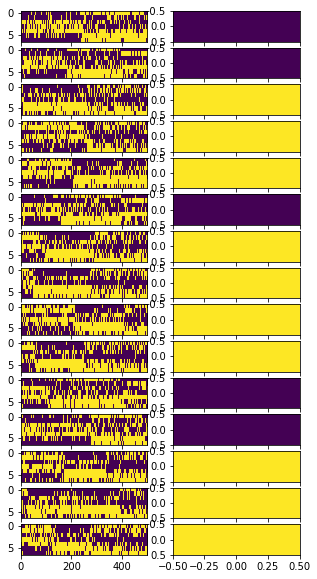

In [43]:
fig, ax = plt.subplots(data_vec.shape[0], 2,sharex='col', sharey='col', figsize = (5,10))
for num, this_dat in enumerate(data_vec):
    ax[num,0].imshow(this_dat,cmap='viridis', aspect='auto')
    ax[num,1].imshow(component_inds[num][np.newaxis,np.newaxis], aspect='auto',vmin=0,vmax=1)

In [44]:
bin_width = 10
fin_length = int(length/bin_width)
idx = np.arange(fin_length)

data_vec_binned = np.sum(np.reshape(data_vec,(*data_vec.shape[:2],-1,bin_width)),axis=-1)
true_r_binned = np.sum(np.reshape(true_r,(*true_r.shape[:2],-1,bin_width)),axis=-1)

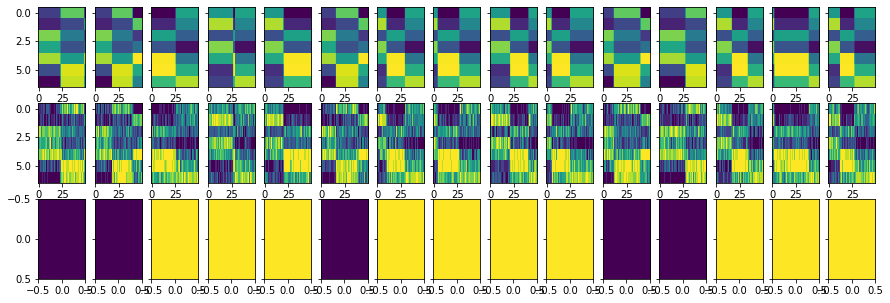

In [45]:
fig, ax = plt.subplots(3,data_vec.shape[0],sharex='row', sharey='row', figsize = (15,5))
for num in range(len(data_vec)):
    ax[0,num].imshow(true_r_binned[num],cmap='viridis', aspect='auto')
    ax[1,num].imshow(data_vec_binned[num],cmap='viridis', aspect='auto')
    ax[2,num].imshow(component_inds[num][np.newaxis,np.newaxis], aspect='auto',vmin=0,vmax=1)

In [46]:
mean_vals = np.array([np.mean(x,axis=(0,-1)) for x in np.array_split(data_vec,states,axis=-1)]).T

In [47]:
with pm.Model() as model:
    alpha_w = pm.Gamma('alpha_w',7.5,1,shape = n_components)
    w = pm.Dirichlet('w', a=alpha_w, shape = (trials,n_components))
    exp_rate = 1/10
    
    
    # Beta distributions of size "nrn"
    
    clust0_lambda = tt.stack([pm.Exponential('l00',exp_rate, shape = (neurons)),
                             pm.Exponential('l01',exp_rate, shape = (neurons)),
                             pm.Exponential('l02',exp_rate, shape = (neurons))])
    clust1_lambda = tt.stack([pm.Exponential('l10',exp_rate, shape = (neurons)),
                             pm.Exponential('l11',exp_rate, shape = (neurons)),
                             pm.Exponential('l12',exp_rate, shape = (neurons))])
    lambdas = tt.stack([clust0_lambda,clust1_lambda])
    
    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((trials,1,fin_length)),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((trials,1,fin_length))],axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)[:,:,np.newaxis,:]
    
    selected_lambdas = tt.tensordot(w,lambdas,[1,0])[...,np.newaxis]
    
    lambda_ = tt.sum(selected_lambdas*weight_stack,axis=1)
    
    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=data_vec_binned)

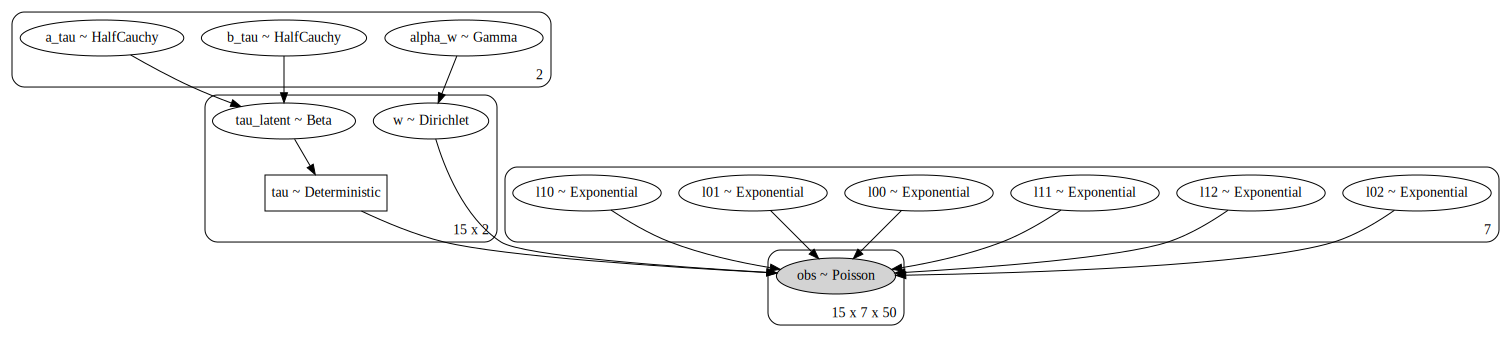

In [48]:
pm.model_to_graphviz(model)

In [49]:
# with model:     
#     step = pm.Metropolis()
#     #step = pm.NUTS()
#     trace = pm.sample(step=step)
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference)
    trace = approx.sample(draws=samples)

  0%|          | 0/100000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 10,211: 100%|██████████| 100000/100000 [01:21<00:00, 1229.39it/s]
Finished [100%]: Average Loss = 10,211


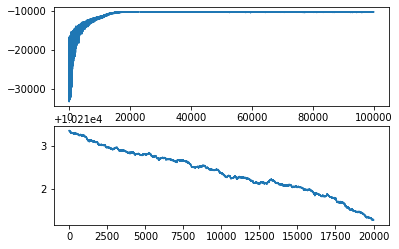

In [50]:
#pm.traceplot(trace);
fig,ax = plt.subplots(2,1)
ax[0].plot(-inference.hist)
len_hist = len(-inference.hist)
kern_len = 5000
#ax[1].plot(-np.median(np.reshape(inference.hist[int(0.75*len_hist):],(-1,100)),axis=-1))
ax[1].plot(np.convolve(inference.hist[int(0.75*len_hist):], np.ones(kern_len)/kern_len, mode='valid'))

In [51]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)
mean_ppc_obs = np.mean(ppc_trace['obs'],axis=0)

100%|██████████| 2000/2000 [00:05<00:00, 386.72it/s]


In [52]:
tau_samples = trace['tau']
int_tau = np.vectorize(np.int)(tau_samples)
mode_tau = stats.mode(int_tau,axis=0)[0][0]
hist_tau = np.array([np.histogram(trial, bins = np.arange(20))[0] for trial in int_tau.swapaxes(0,1)])

In [53]:
w_samples = trace['w']
w_samples_long = np.reshape(w_samples,(-1,w_samples.shape[-1]))
mean_w = np.mean(w_samples,axis=0)
categorical_w = np.argmax(mean_w,axis=-1)

In [54]:
cat_accuracy_list = [np.sum(categorical_w==component_inds),
                      np.sum((1-categorical_w)==component_inds)]
model_ind = np.int(np.argmax(cat_accuracy_list))
if model_ind:
    categorical_w = 1-categorical_w
cat_accuracy = cat_accuracy_list[model_ind]

hist_out = np.histogram2d(*w_samples_long.T,bins=50)
diag_vals = np.diag(np.flip(hist_out[0],axis=-1))

components_hist = np.histogram(component_inds,np.arange(3))[0]
components_hist = components_hist/np.max(components_hist)

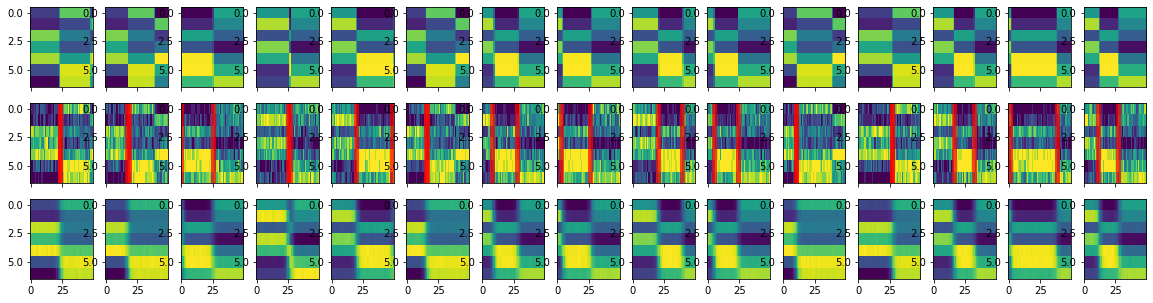

In [55]:
fig, ax = plt.subplots(3,trials,figsize = (20,5),sharex=True)
for trial in range(trials):
    ax[0,trial].imshow(true_r_binned[trial],cmap='viridis',aspect='auto')
    ax[1,trial].vlines(mode_tau[trial],-0.5,neurons-0.5, lw = 5, color='red',alpha = 0.7)
    ax[1,trial].imshow(data_vec_binned[trial],cmap='viridis',aspect='auto')
    ax[2,trial].imshow(mean_ppc_obs[trial],cmap='viridis',aspect='auto')

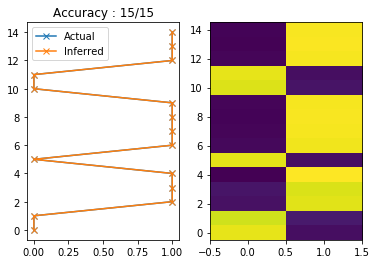

In [56]:
fig,ax = plt.subplots(1,2)
ax[0].plot(component_inds, np.arange(trials),'-x',label='Actual')
ax[0].plot(categorical_w, np.arange(trials),'-x', label='Inferred')
ax[0].set_title(f'Accuracy : {cat_accuracy}/{categorical_w.shape[0]}')
ax[0].legend()
ax[1].imshow(mean_w,aspect='auto',origin='lower');
